# **SKKU AI (Spring 2023)**
### Lab 7: Famous CNN Architectures (In-class activity for Week 10)

**NOTE**
Some descriptions & codes from the below resources:
1. https://keras.io/api/applications/
2. CS231n: Convolutional Neural Networks for Visual Recognition at Stanford Univ (https://cs231n.github.io/)
---

**The below summary and Convolution Demo from CS231n Lecture Note from Standford Univ.**

* Source: https://cs231n.github.io/convolutional-networks/

## Convolutional Layer Summary

#### Summary.
To summarize, the Conv Layer:

* Accepts a volume of size W1×H1×D1
* Requires four hyperparameters:
 * Number of filters K,
 * their spatial extent F,
 * the stride S,
 * the amount of zero padding P.
* Produces a volume of size W2×H2×D2 where:
 * W2=(W1−F+2P)/S+1
 * H2=(H1−F+2P)/S+1 (i.e. width and height are computed equally by symmetry)
 * D2=K

* With parameter sharing, it introduces F⋅F⋅D1 weights per filter, for a total of (F⋅F⋅D1)⋅K weights and K biases.

* In the output volume, the d-th depth slice (of size W2×H2) is the result of performing a valid convolution of the d-th filter over the input volume with a stride of S, and then offset by d-th bias.

**Convolution Demo**.
Below is a running demo of a CONV layer. Since 3D volumes are hard to visualize, all the volumes (the input volume (in blue), the weight volumes (in red), the output volume (in green)) are visualized with each depth slice stacked in rows.

The input volume is of size **W1=5,H1=5,D1=3**, and the CONV layer parameters are **K=2,F=3,S=2,P=1**. That is, we have two filters of size 3×3, and they are applied with a stride of 2. Therefore, the output volume size has spatial size (5 - 3 + 2)/2 + 1 = 3.

 Moreover, notice that a padding of **P=1** is applied to the input volume, making the outer border of the input volume zero. The visualization below iterates over the output activations (green), and shows that each element is computed by elementwise multiplying the highlighted input (blue) with the filter (red), summing it up, and then offsetting the result by the bias.

In [ ]:
from IPython.display import HTML

HTML('<iframe width="1024" height="768" src="https://cs231n.github.io/assets/conv-demo/index.html"" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

## Pooling Layer Summary

It is common to periodically insert a Pooling layer in-between successive Conv layers in a ConvNet architecture. Its function is to progressively reduce the spatial size of the representation to reduce the amount of parameters and computation in the network, and hence to also control overfitting. The Pooling Layer operates independently on every depth slice of the input and resizes it spatially, using the MAX operation. The most common form is a pooling layer with filters of size 2x2 applied with a stride of 2 downsamples every depth slice in the input by 2 along both width and height, discarding 75% of the activations. Every MAX operation would in this case be taking a max over 4 numbers (little 2x2 region in some depth slice). The depth dimension remains unchanged. More generally, the pooling layer:

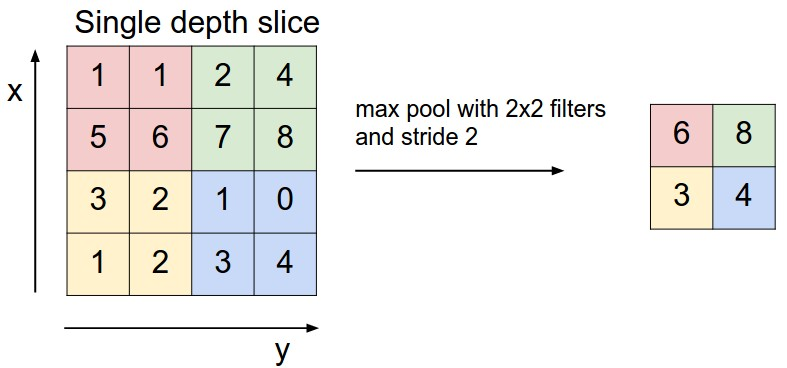

## 0. Loading the SKKU binary classification dataset

#### Mount Google Drive & Files

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import zipfile

local_zip = '/content/drive/MyDrive/AI_Spring2023/assignment1.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [ ]:
base_dir = '/tmp/dataset'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

# Directory with our training plane pictures
train_planes_dir = os.path.join(train_dir, 'planes')

# Directory with our training no plane pictures
train_no_planes_dir = os.path.join(train_dir, 'no_planes')

# Directory with our test plane pictures
test_planes_dir = os.path.join(test_dir, 'planes')

# Directory with our test no plane pictures
test_no_planes_dir = os.path.join(test_dir, 'no_planes')

In [ ]:
print('total training planes images:', len(os.listdir(train_planes_dir)))
print('total training no_planes images:', len(os.listdir(train_no_planes_dir)))
print('total test planes images:', len(os.listdir(test_planes_dir)))
print('total test no_planes images:', len(os.listdir(test_no_planes_dir)))

total training planes images: 1000
total training no_planes images: 1000
total test planes images: 500
total test no_planes images: 500


#### Loading the dataset using keras.preprocessing

Let's load these images off disk using the helpful [image_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory) utility. This will take you from a directory of images on disk to a `tf.data.Dataset` in just a couple lines of code. If you like, you can also write your own data loading code from scratch by visiting the [load images](https://www.tensorflow.org/tutorials/load_data/images) tutorial.

In [ ]:
import tensorflow as tf
from tensorflow import keras

################################
batch_size = 32
num_of_train_imgs = 2000
num_of_test_imgs = 1000
img_height = 50
img_width = 50

################################

# Train
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=num_of_train_imgs)

# Validation
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=num_of_train_imgs)

# Test
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_dir,
  image_size=(img_height, img_width),
  batch_size=num_of_test_imgs)

Found 2000 files belonging to 2 classes.
Using 1600 files for training.
Found 2000 files belonging to 2 classes.
Using 400 files for validation.
Found 1000 files belonging to 2 classes.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['no_planes', 'planes']


## 1. Baseline - A Simple CNN model

Our simple CNN model that we used in the previous week!

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import Model

# Our input feature map is 50x50x3: 50x50 for the image pixels, and 3 for
# the three color channels: R, G, and B
img_input = layers.Input(shape=(150, 150, 3))

# First convolution extracts 16 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(16, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)

# Second convolution extracts 32 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Third convolution extracts 64 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Flatten feature map to a 1-dim tensor so we can add fully connected layers
x = layers.Flatten()(x)

# Create a fully connected layer with ReLU activation and 512 hidden units
x = layers.Dense(512, activation='relu')(x)

# Create output layer with a single node and sigmoid activation
output = layers.Dense(1, activation='sigmoid')(x)

# Create model:
# input = input feature map
# output = input feature map + stacked convolution/maxpooling layers + fully 
# connected layer + sigmoid output layer
model = Model(img_input, output)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496 

In [ ]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['acc'])

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 16 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=16,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow test images in batches of 20 using test_datagen generator
test_generator = val_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

history = model.fit_generator(
      train_generator,
      epochs=15,
      validation_data=test_generator)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/15


<ipython-input-9-7cc11ef471aa>:22: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


125/125 [==============================] - 18s 55ms/step - loss: 0.4534 - acc: 0.7965 - val_loss: 0.3361 - val_acc: 0.8520
Epoch 2/15
125/125 [==============================] - 8s 63ms/step - loss: 0.2312 - acc: 0.9170 - val_loss: 0.1798 - val_acc: 0.9240
Epoch 3/15
125/125 [==============================] - 6s 47ms/step - loss: 0.1755 - acc: 0.9325 - val_loss: 0.1552 - val_acc: 0.9390
Epoch 4/15
125/125 [==============================] - 8s 60ms/step - loss: 0.1377 - acc: 0.9460 - val_loss: 0.1924 - val_acc: 0.9300
Epoch 5/15
125/125 [==============================] - 6s 47ms/step - loss: 0.1007 - acc: 0.9650 - val_loss: 0.1471 - val_acc: 0.9410
Epoch 6/15
125/125 [==============================] - 6s 49ms/step - loss: 0.0667 - acc: 0.9745 - val_loss: 0.1604 - val_acc: 0.9400
Epoch 7/15
125/125 [==============================] - 7s 54ms/step - loss: 0.0561 - acc: 0.9790 - val_loss: 0.2130 - val_acc: 0.9300
Epoch 8/15
125/125 [==============================] - 7s 53ms/step - loss: 0.04

Text(0.5, 1.0, 'Training and validation loss')

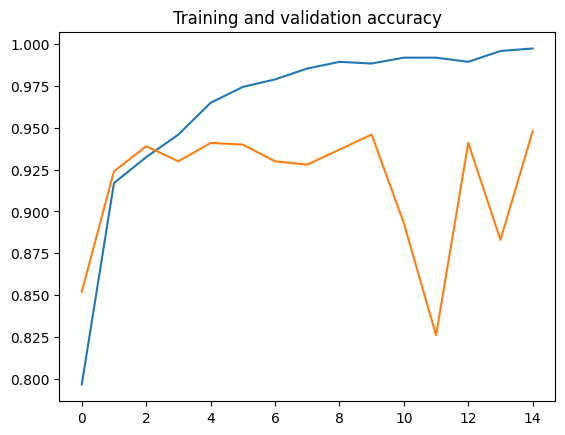

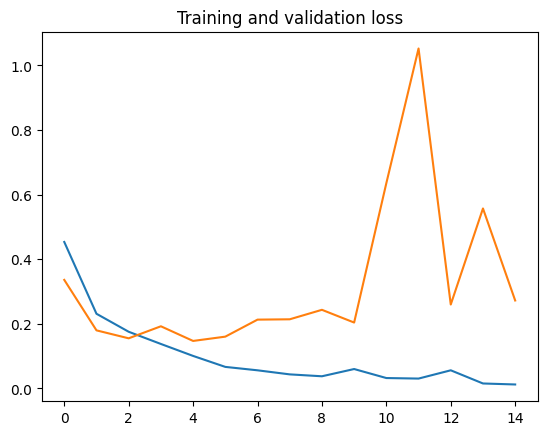

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt

# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

## 2. AlexNet

AlexNet is the name of a convolutional neural network (CNN) architecture, designed by Alex Krizhevsky in collaboration with Ilya Sutskever and Geoffrey Hinton, who was Krizhevsky's Ph.D. advisor

AlexNet competed in the ImageNet Large Scale Visual Recognition Challenge on September 30, 2012.The network achieved a top-5 error of 15.3%, more than 10.8 percentage points lower than that of the runner up. The original paper's primary result was that the depth of the model was essential for its high performance, which was computationally expensive, but made feasible due to the utilization of graphics processing units (GPUs) during training.
(from https://en.wikipedia.org/wiki/AlexNet)


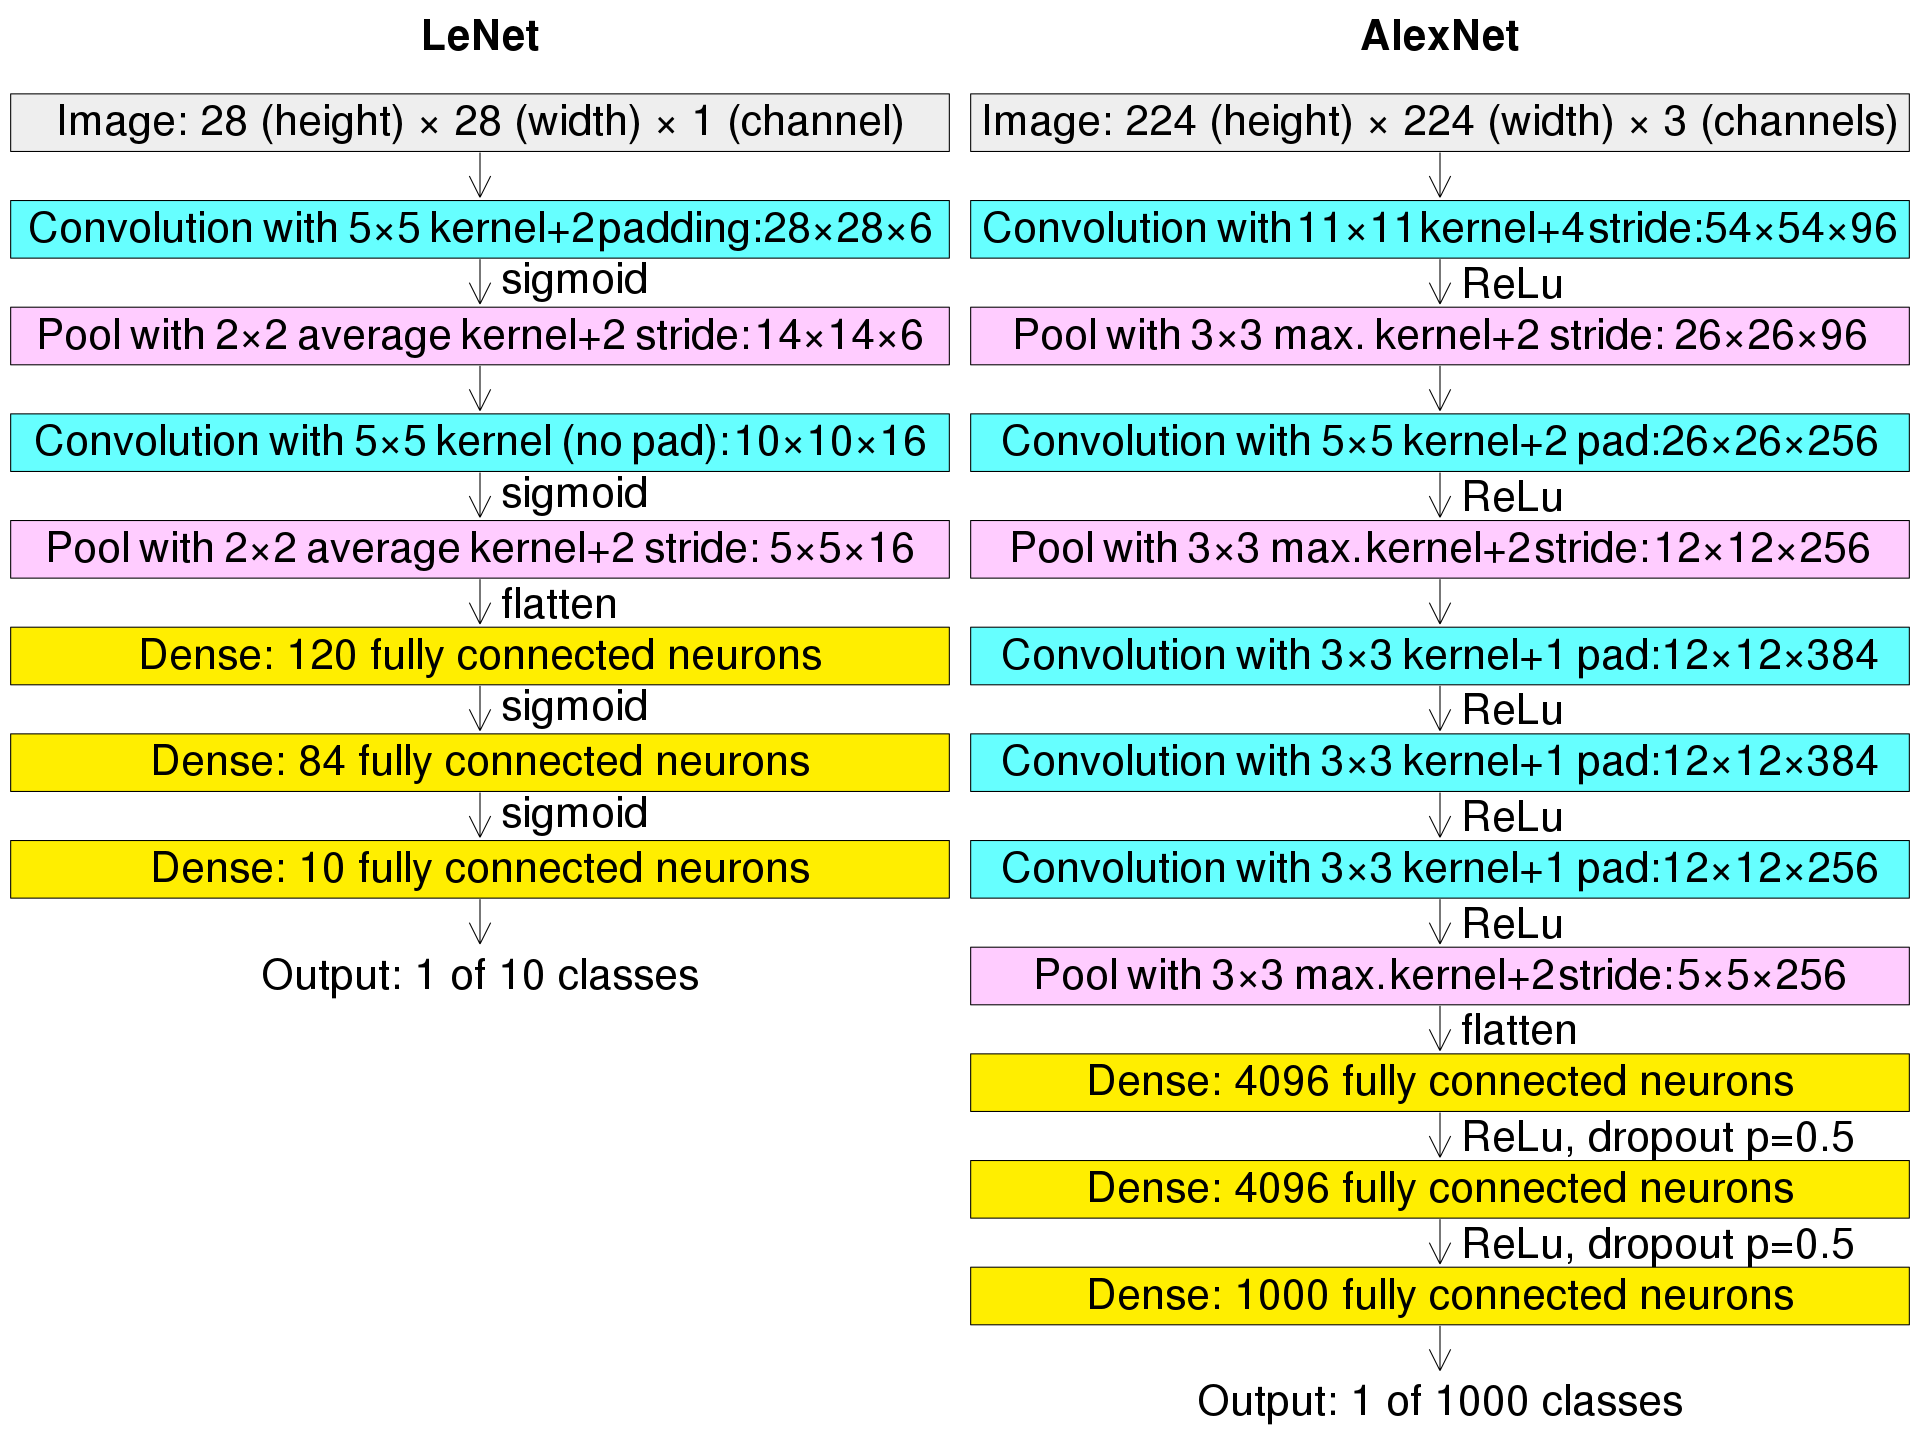

In [ ]:
"""
AlexNet Keras Implementation
BibTeX Citation:
@inproceedings{krizhevsky2012imagenet,
  title={Imagenet classification with deep convolutional neural networks},
  author={Krizhevsky, Alex and Sutskever, Ilya and Hinton, Geoffrey E},
  booktitle={Advances in neural information processing systems},
  pages={1097--1105},
  year={2012}
}

code from: https://github.com/eweill/keras-deepcv/blob/master/models/classification/alexnet.py
"""

# Import necessary packages
import argparse

# Import necessary components to build LeNet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2

def alexnet_model(img_shape=(224, 224, 3), n_classes=10, l2_reg=0.,
	weights=None):

	# Initialize model
	alexnet = Sequential()

	# Layer 1
	alexnet.add(Conv2D(96, (11, 11), input_shape=img_shape,
		padding='same', kernel_regularizer=l2(l2_reg)))
	alexnet.add(BatchNormalization())
	alexnet.add(Activation('relu'))
	alexnet.add(MaxPooling2D(pool_size=(2, 2)))

	# Layer 2
	alexnet.add(Conv2D(256, (5, 5), padding='same'))
	alexnet.add(BatchNormalization())
	alexnet.add(Activation('relu'))
	alexnet.add(MaxPooling2D(pool_size=(2, 2)))

	# Layer 3
	alexnet.add(ZeroPadding2D((1, 1)))
	alexnet.add(Conv2D(512, (3, 3), padding='same'))
	alexnet.add(BatchNormalization())
	alexnet.add(Activation('relu'))
	alexnet.add(MaxPooling2D(pool_size=(2, 2)))

	# Layer 4
	alexnet.add(ZeroPadding2D((1, 1)))
	alexnet.add(Conv2D(1024, (3, 3), padding='same'))
	alexnet.add(BatchNormalization())
	alexnet.add(Activation('relu'))

	# Layer 5
	alexnet.add(ZeroPadding2D((1, 1)))
	alexnet.add(Conv2D(1024, (3, 3), padding='same'))
	alexnet.add(BatchNormalization())
	alexnet.add(Activation('relu'))
	alexnet.add(MaxPooling2D(pool_size=(2, 2)))

	# Layer 6
	alexnet.add(Flatten())
	alexnet.add(Dense(3072))
	alexnet.add(BatchNormalization())
	alexnet.add(Activation('relu'))
	alexnet.add(Dropout(0.5))

	# Layer 7
	alexnet.add(Dense(4096))
	alexnet.add(BatchNormalization())
	alexnet.add(Activation('relu'))
	alexnet.add(Dropout(0.5))

	# Layer 8
	alexnet.add(Dense(n_classes))
	alexnet.add(BatchNormalization())
	#alexnet.add(Activation('softmax'))
	alexnet.add(Activation('sigmoid'))

	if weights is not None:
		alexnet.load_weights(weights)

	return alexnet

In [ ]:
# Create AlexNet model
model = alexnet_model(img_shape=(150, 150, 3), n_classes=1)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 150, 150, 96)      34944     
                                                                 
 batch_normalization (BatchN  (None, 150, 150, 96)     384       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 150, 150, 96)      0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 75, 75, 96)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 75, 75, 256)       614656    
                                                                 
 batch_normalization_1 (Batc  (None, 75, 75, 256)      1

In [ ]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['acc'])

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 16 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=16,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow test images in batches of 20 using test_datagen generator
test_generator = val_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

history = model.fit_generator(
      train_generator,
      epochs=15,
      validation_data=test_generator)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/15


<ipython-input-14-7cc11ef471aa>:22: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


125/125 [==============================] - 46s 270ms/step - loss: 0.4201 - acc: 0.8740 - val_loss: 0.7140 - val_acc: 0.6600
Epoch 2/15
125/125 [==============================] - 31s 249ms/step - loss: 0.3704 - acc: 0.9090 - val_loss: 0.6950 - val_acc: 0.6560
Epoch 3/15
125/125 [==============================] - 32s 252ms/step - loss: 0.3333 - acc: 0.9235 - val_loss: 0.4487 - val_acc: 0.7780
Epoch 4/15
125/125 [==============================] - 31s 252ms/step - loss: 0.2993 - acc: 0.9365 - val_loss: 0.6395 - val_acc: 0.6560
Epoch 5/15
125/125 [==============================] - 32s 254ms/step - loss: 0.2701 - acc: 0.9445 - val_loss: 0.4759 - val_acc: 0.7600
Epoch 6/15
125/125 [==============================] - 32s 255ms/step - loss: 0.2447 - acc: 0.9560 - val_loss: 0.3040 - val_acc: 0.9250
Epoch 7/15
125/125 [==============================] - 33s 262ms/step - loss: 0.2196 - acc: 0.9670 - val_loss: 0.2393 - val_acc: 0.9330
Epoch 8/15
125/125 [==============================] - 32s 259ms/st

Text(0.5, 1.0, 'Training and validation loss')

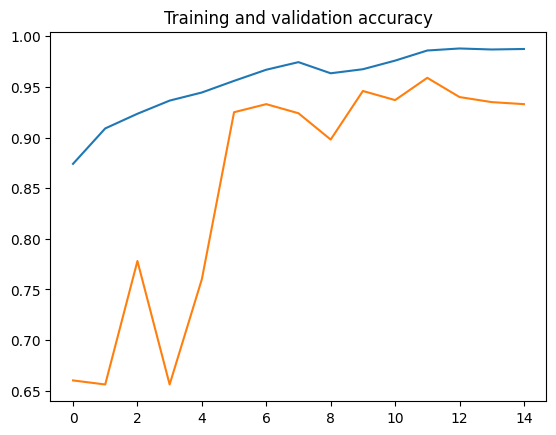

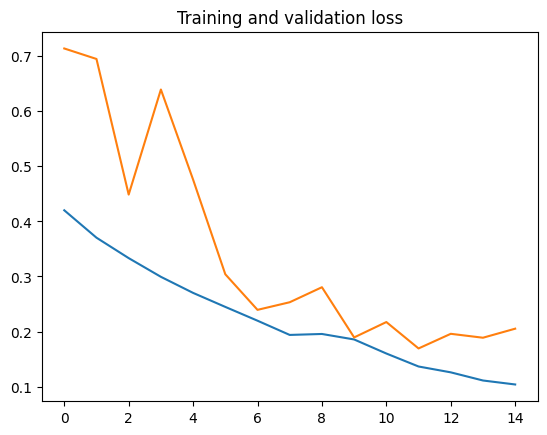

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt

# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

## 3. Going Deeper (VGGNet & GoogLeNet)
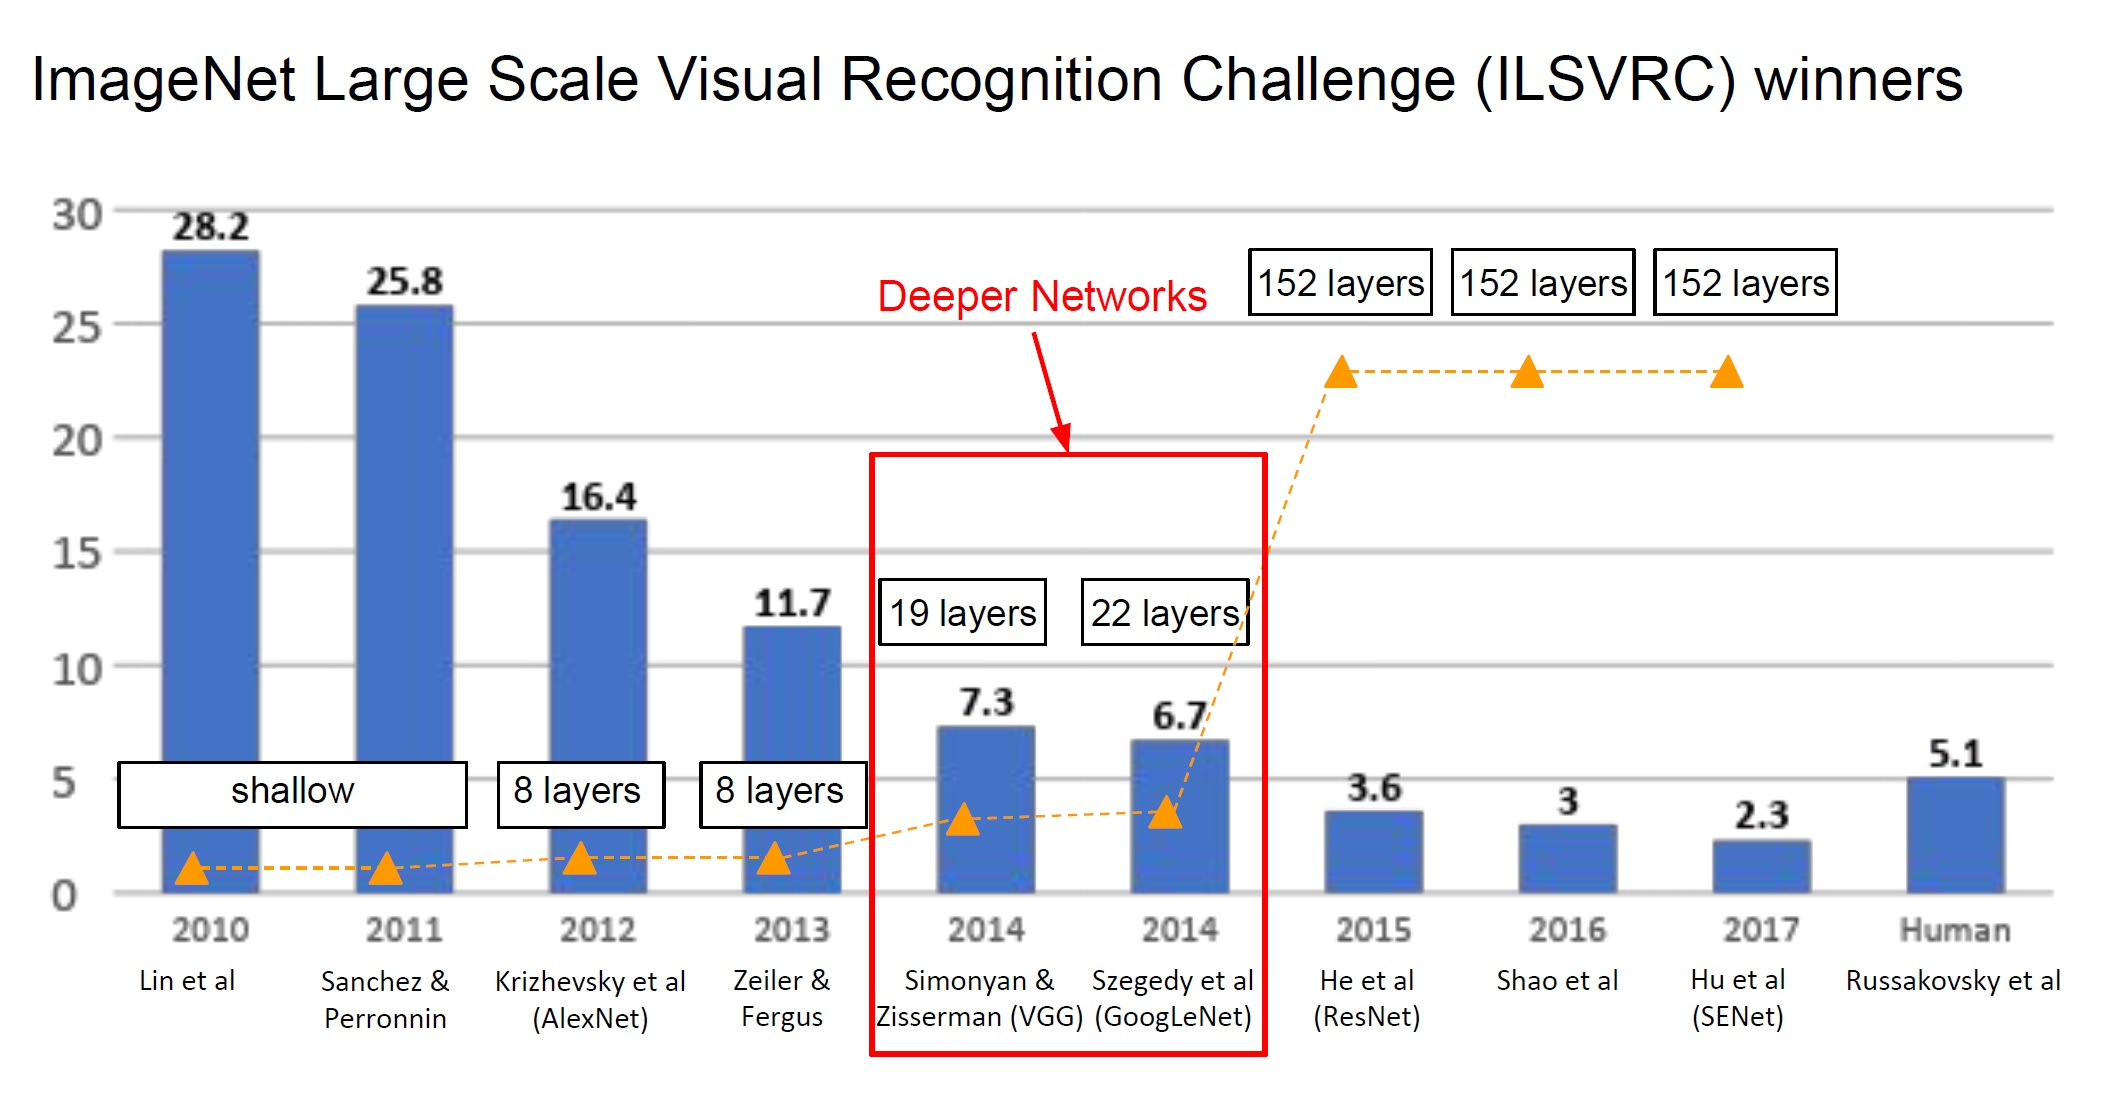

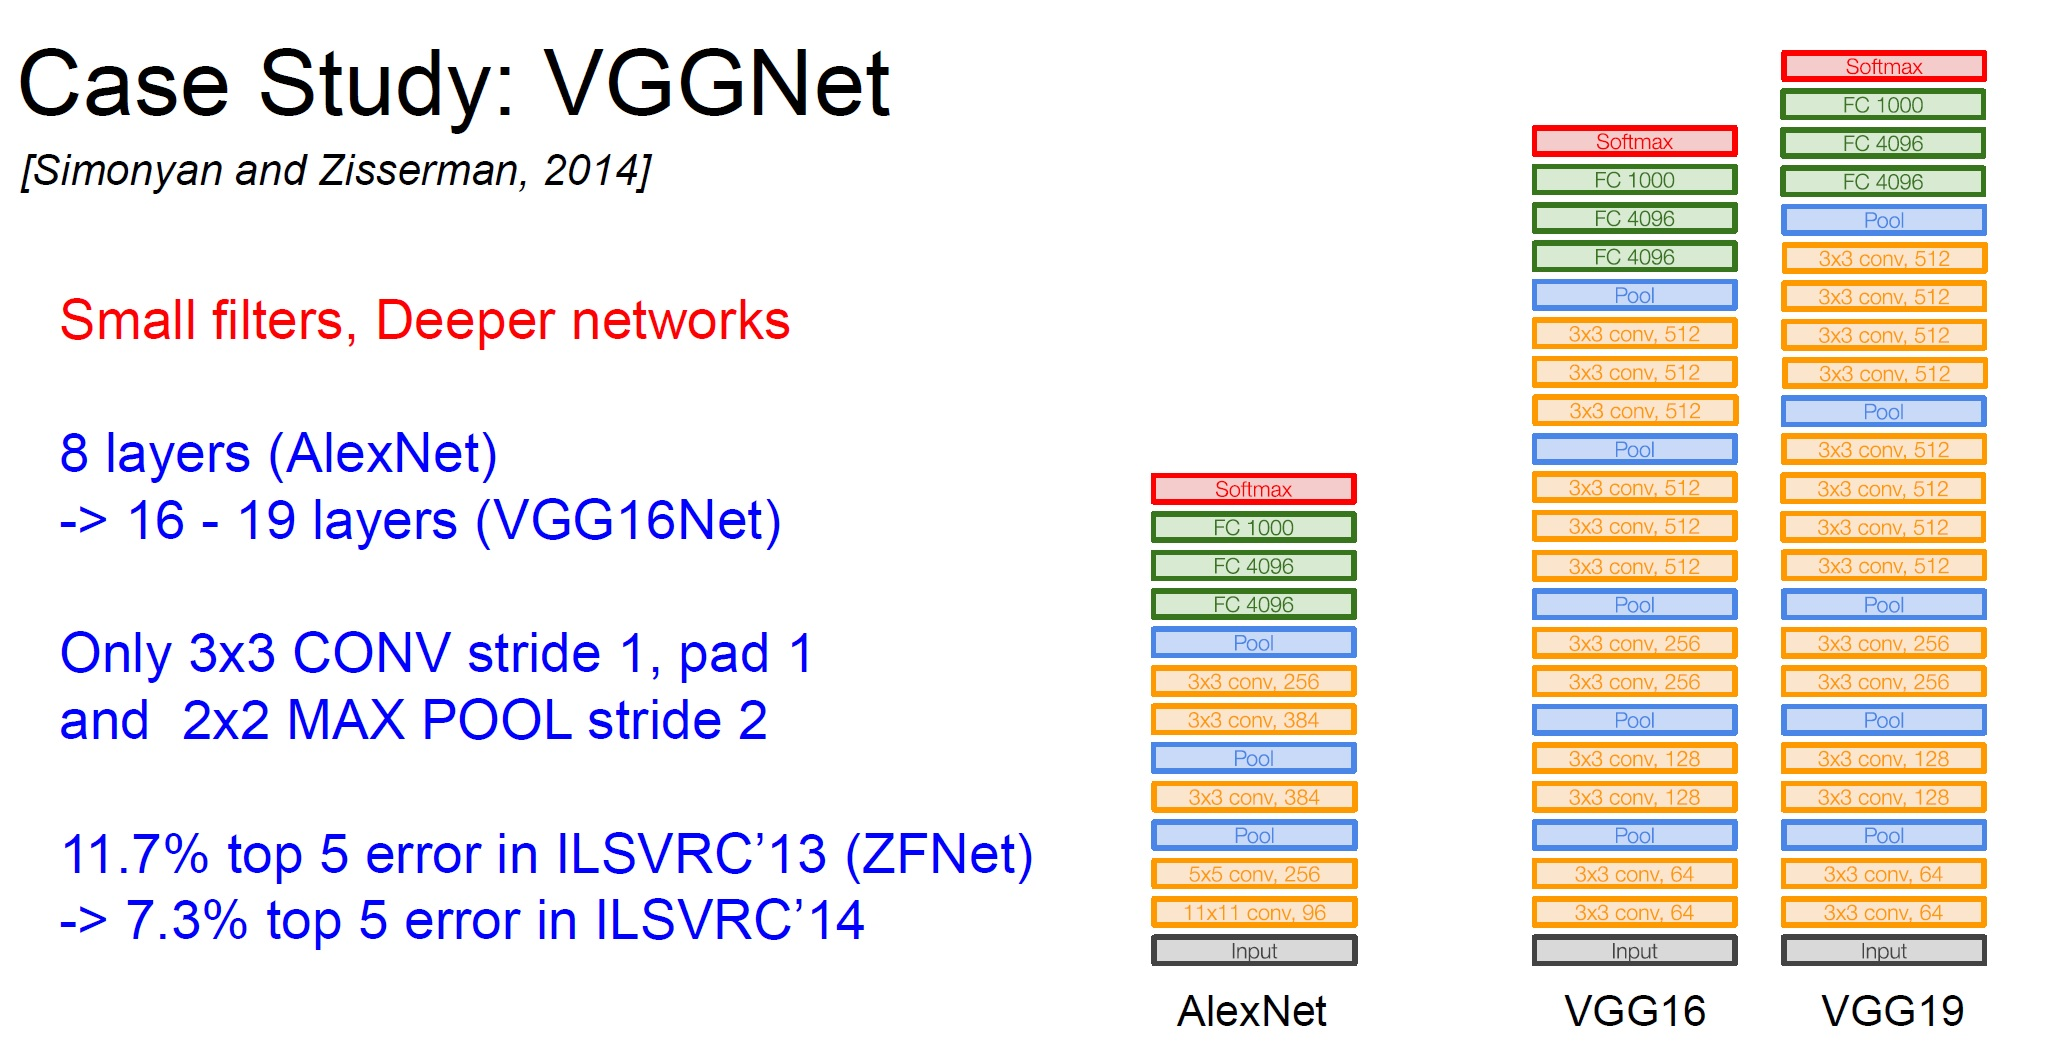

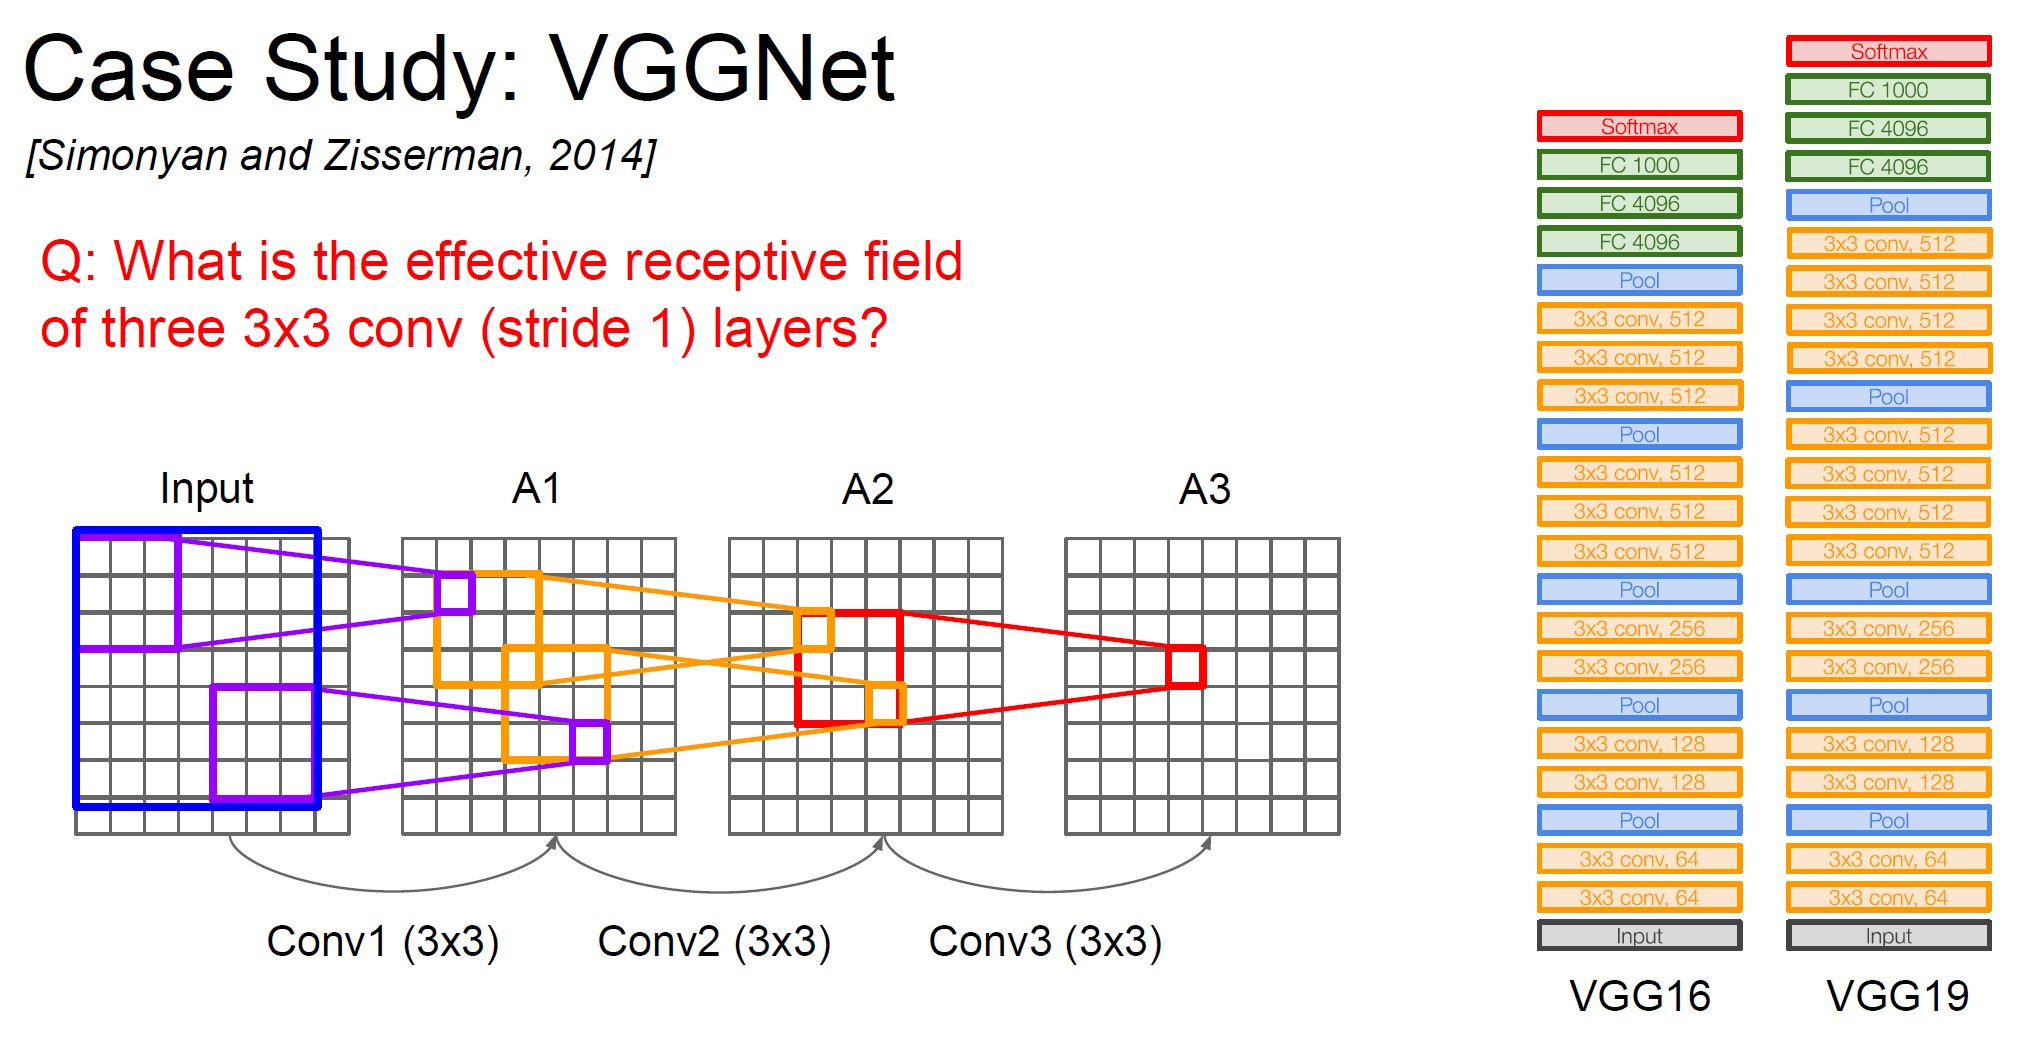

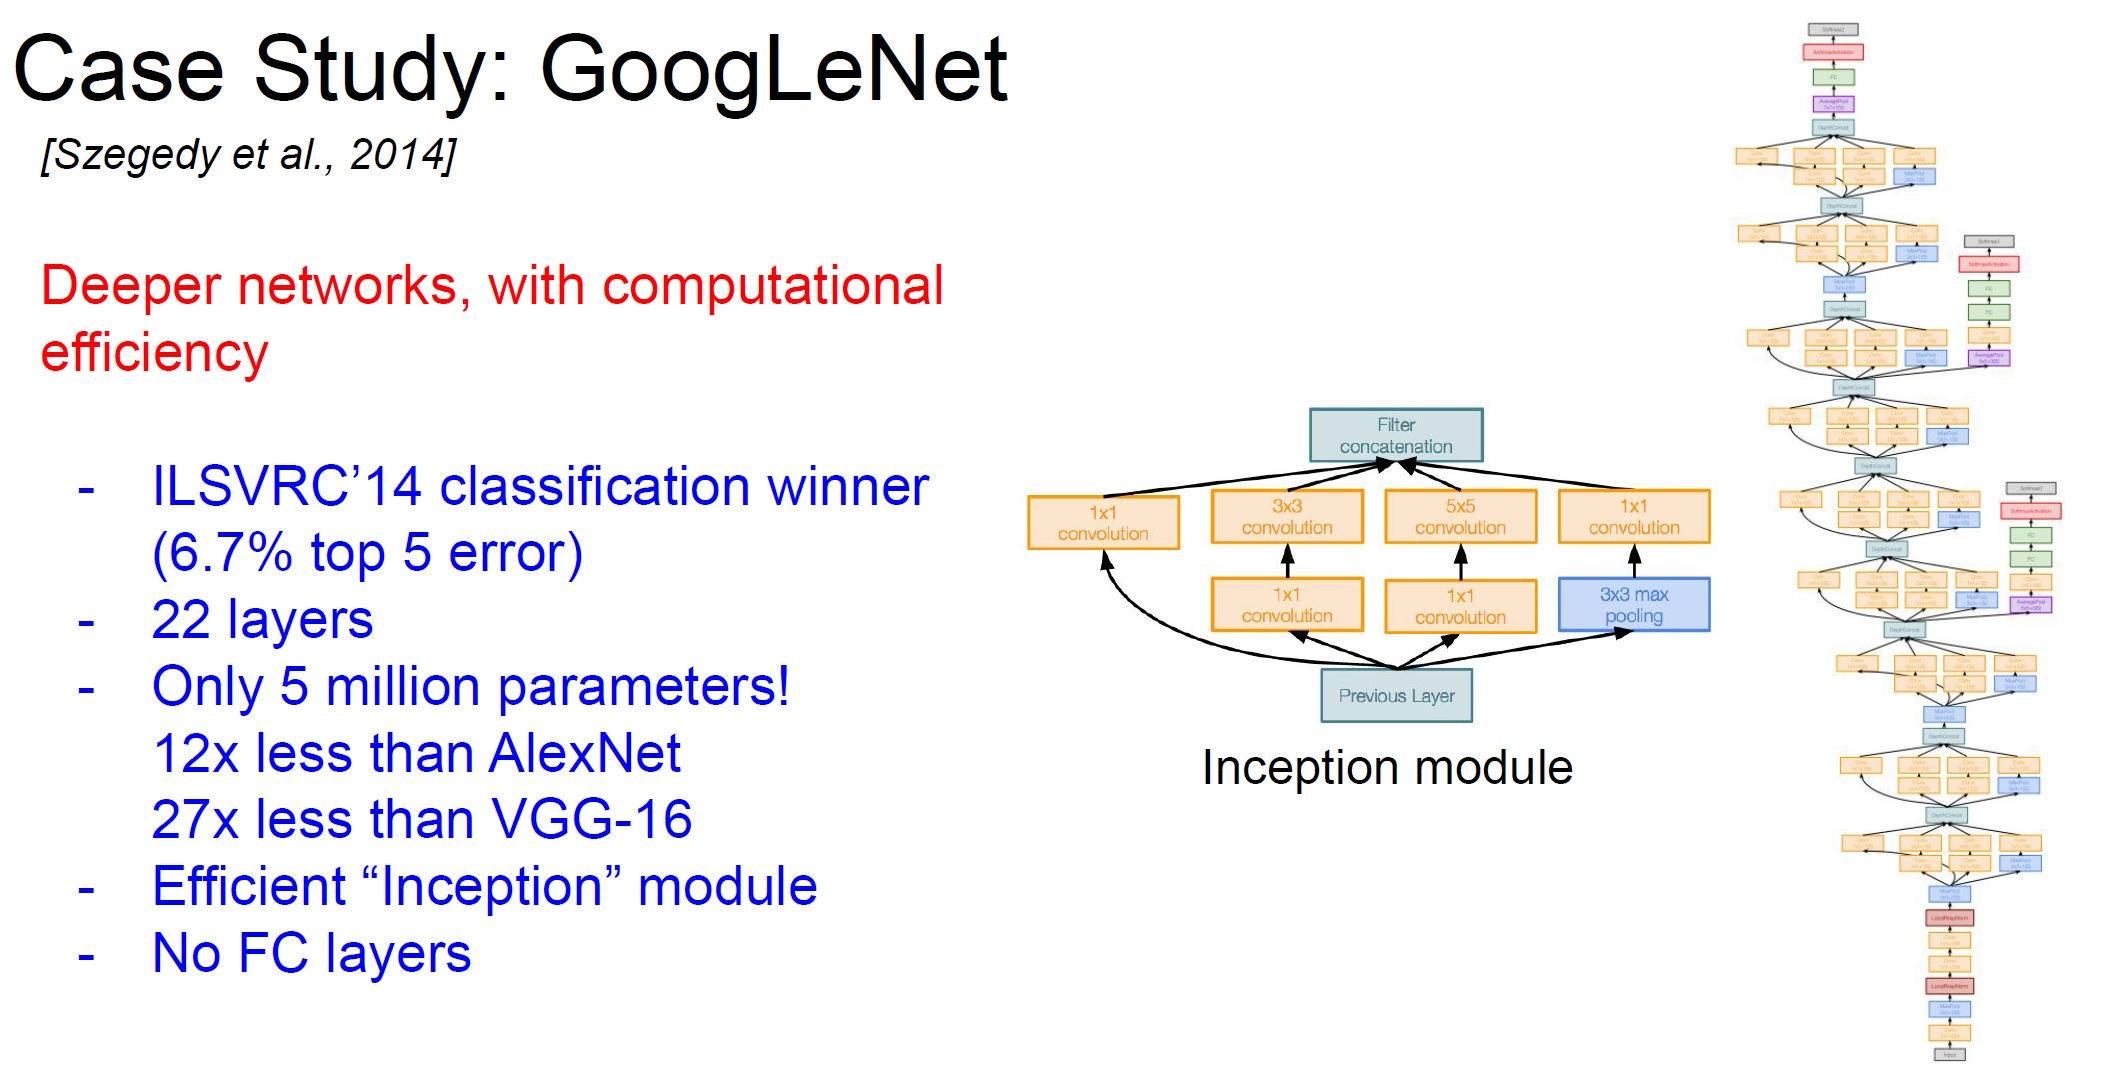

## 4. ResNet

To avoid gradient vanishing or exploding problems!

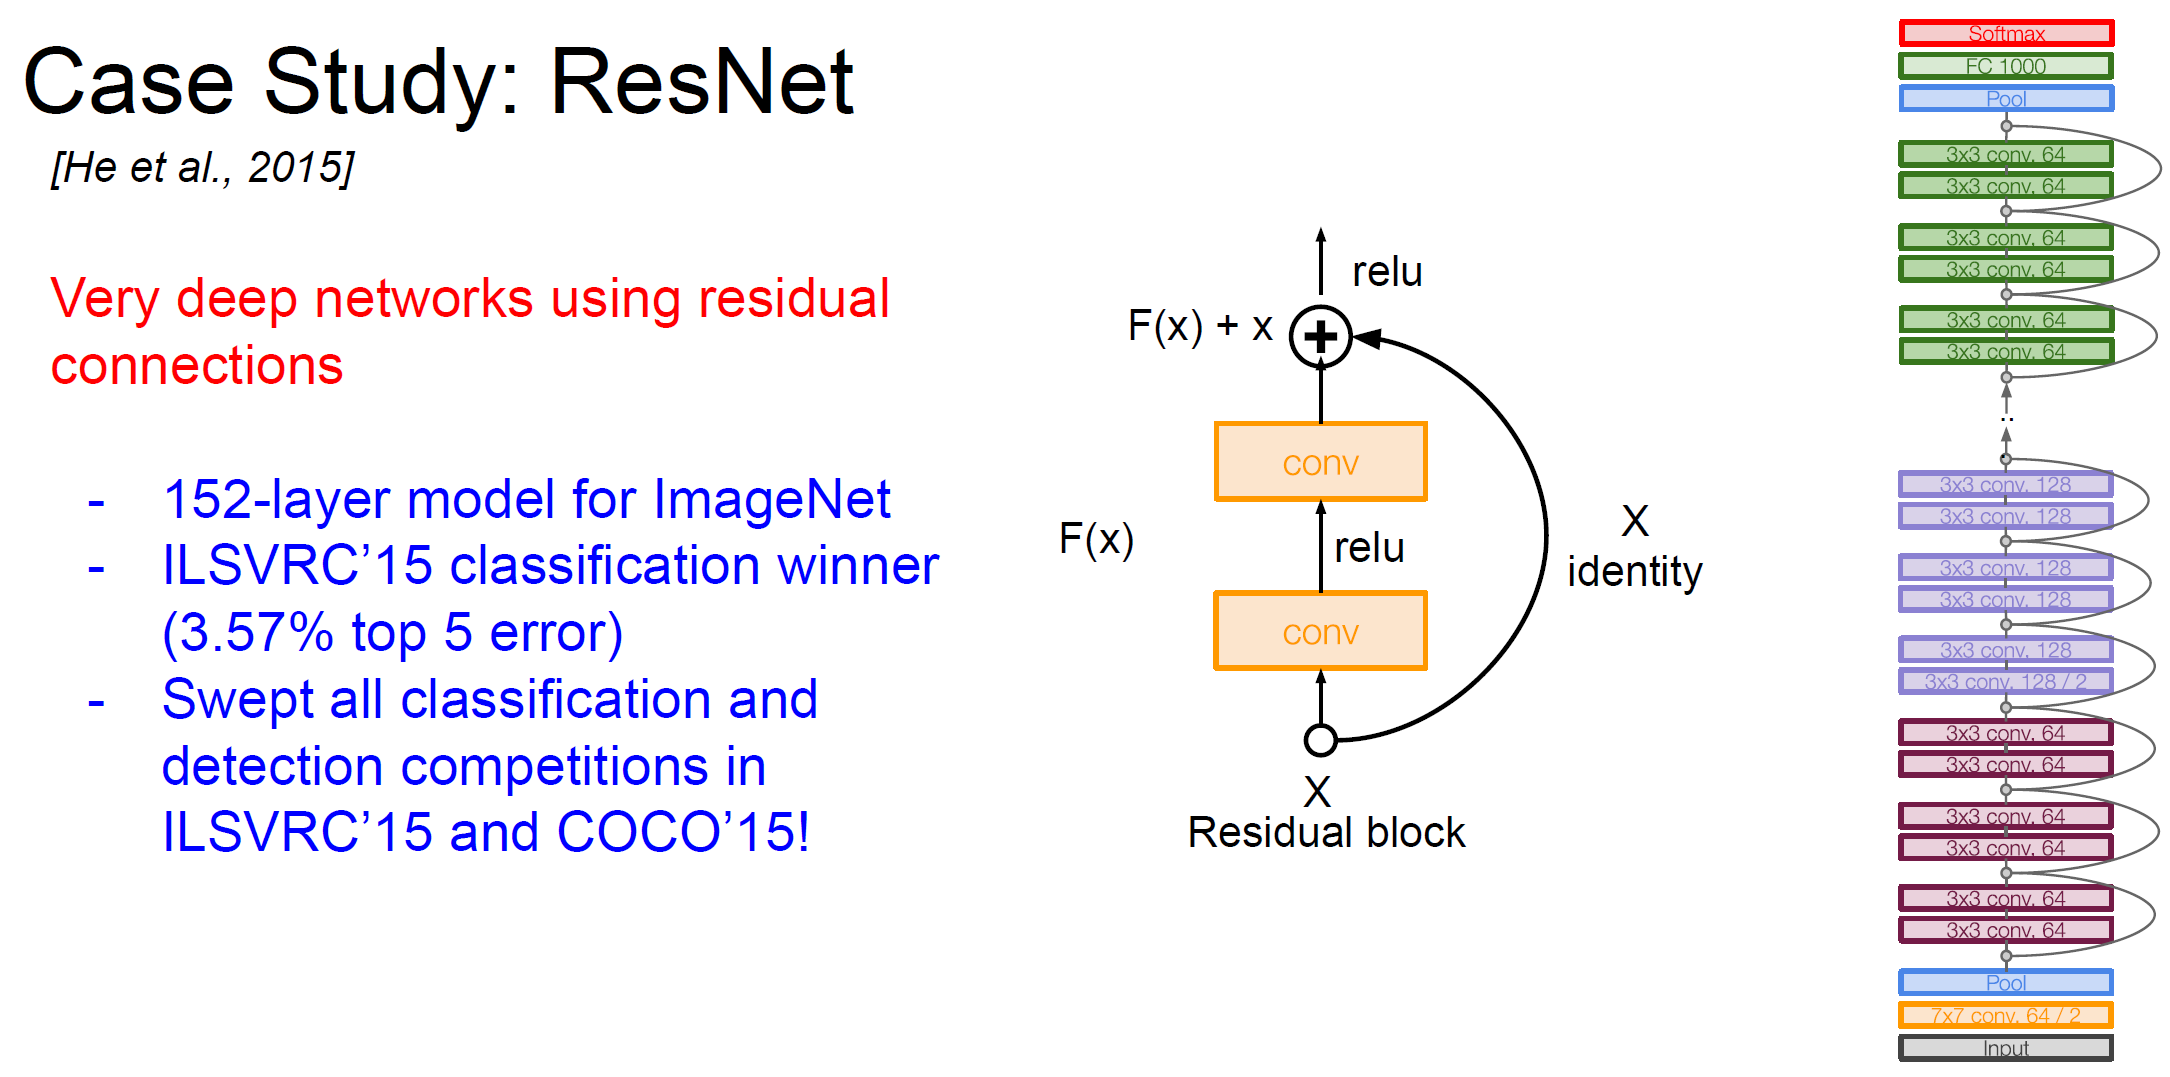

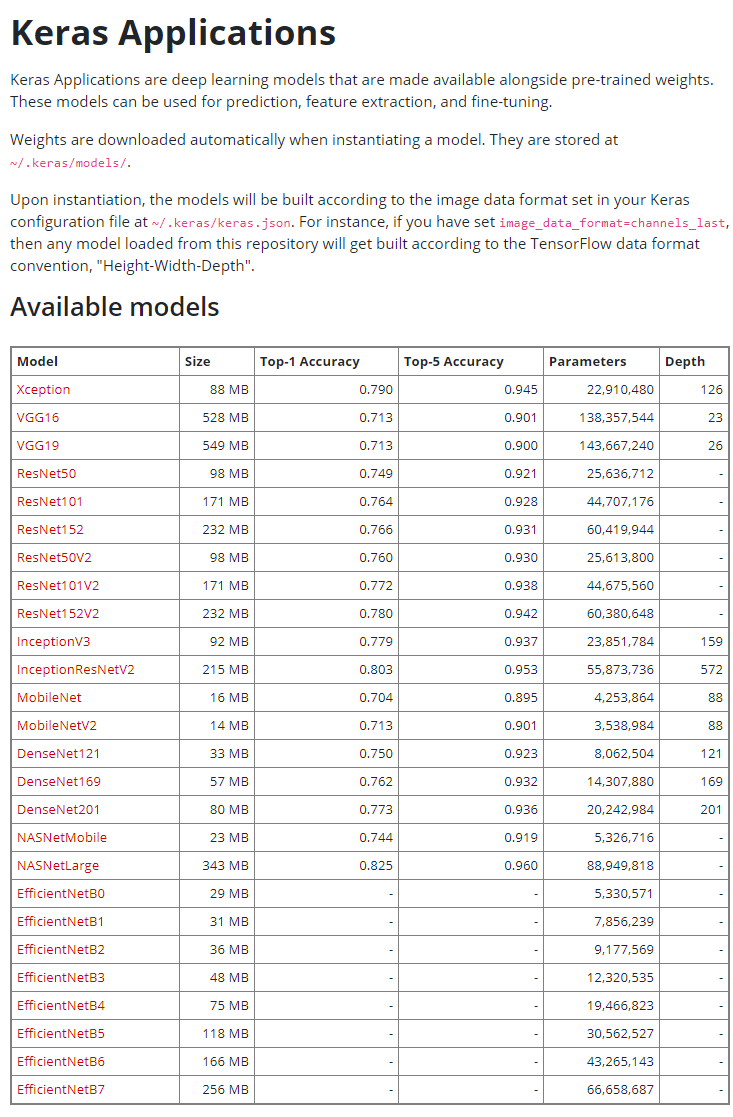

https://keras.io/api/applications/

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import Model

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

base_model = ResNet50(weights='imagenet', input_tensor=Input(shape=(150, 150, 3)))
#base_model.summary()

x = base_model.get_layer('avg_pool').output
# Create output layer with a single node and sigmoid activation
output = layers.Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)
model.summary()

102967424/102967424 [==============================] - 0s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormaliza

In [ ]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['acc'])

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 16 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=16,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow test images in batches of 20 using test_datagen generator
test_generator = val_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

history = model.fit_generator(
      train_generator,
      epochs=15,
      validation_data=test_generator)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/15


<ipython-input-18-7cc11ef471aa>:22: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


125/125 [==============================] - 50s 135ms/step - loss: 0.5562 - acc: 0.8540 - val_loss: 0.6882 - val_acc: 0.5000
Epoch 2/15
125/125 [==============================] - 15s 122ms/step - loss: 0.1808 - acc: 0.9315 - val_loss: 0.6935 - val_acc: 0.5000
Epoch 3/15
125/125 [==============================] - 16s 127ms/step - loss: 0.1453 - acc: 0.9540 - val_loss: 2.2678 - val_acc: 0.5000
Epoch 4/15
125/125 [==============================] - 15s 123ms/step - loss: 0.1202 - acc: 0.9605 - val_loss: 0.7437 - val_acc: 0.5000
Epoch 5/15
125/125 [==============================] - 16s 127ms/step - loss: 0.0996 - acc: 0.9630 - val_loss: 0.6384 - val_acc: 0.5240
Epoch 6/15
125/125 [==============================] - 18s 147ms/step - loss: 0.0780 - acc: 0.9715 - val_loss: 0.3400 - val_acc: 0.8870
Epoch 7/15
125/125 [==============================] - 16s 124ms/step - loss: 0.0757 - acc: 0.9730 - val_loss: 0.9091 - val_acc: 0.5850
Epoch 8/15
125/125 [==============================] - 15s 123ms/st

Text(0.5, 1.0, 'Training and validation loss')

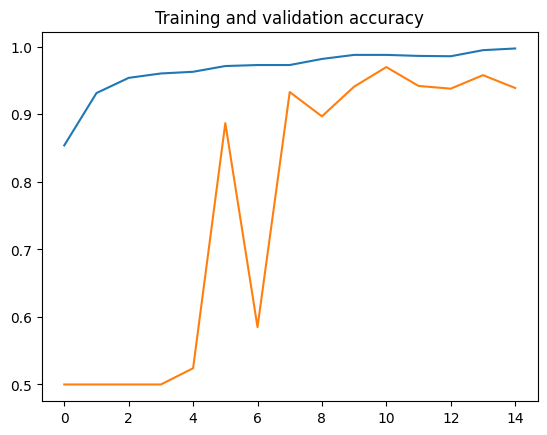

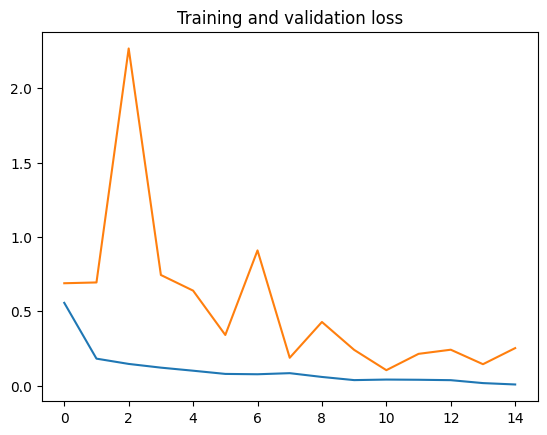

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt

# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

---
## (Simple & Easy!) Lab 7 Activity: Multi-class Image Classification
### Multi-class Image Classification on the SKKU Aircraft dataset

#### 1. SKKU Aircraft Dataset (Multi-classes)
This dataset is constructed based on the below reference dataset [1]. It consists of 5900 images in 10 classes. There are 3934 training images and 1966 test images. Here are the classes in the dataset.

#### 2. Multi-class Image Classification
Given the above SKKU aircraft dataset, build your deep learning model that predicts the aircraft manufacturer given an image. There are a total of 10 aircraft manufacturers in the dataset and each image has only one aircraft that belongs to one of 10 manufacturers.

#### References
[1] Fine-Grained Visual Classification of Aircraft, S. Maji, J. Kannala, E. Rahtu, M. Blaschko, A. Vedaldi, arXiv.org, 2013

In [ ]:
# do fun things!